# 检查准确率

# 1、输入样点数据进行采样


In [1]:
import os
import pandas as pd
import numpy as np
import shutil
import arcpy
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error,mean_squared_log_error
import matplotlib.pyplot as plt
import seaborn as sns
from arcpy import env
from arcpy.management import *
from arcpy.sa import *
from arcpy.da import *
from arcpy.conversion import *

In [2]:
# 分析函数
# 取消并行处理
def disable_parallel_processing(func):
    def wrapper(*args, **kwargs):
        with arcpy.EnvManager(parallelProcessingFactor="0"):
            return func(*args, **kwargs)
    return wrapper
# 采样
def sample_point(point_,raster_,out_name):
    """根据栅格采样点,输出为表格"""
    Sample(raster_,point_,out_name,"NEAREST", "OBJECTID", "CURRENT_SLICE", None, '', None, None, "ROW_WISE", "TABLE")
    return None

# 导出CSV
def export_csv(table_,out_path,out_name):
    TableToTable(table_,out_path,out_name)
    return None

# xy表转点
def xy_to_point(in_table,out_feature_class,x_field,y_field,z_field=None,coordinate_system=arcpy.SpatialReference(4326)):
    """将xy表转点，坐标系默认为WGS84"""
    arcpy.management.XYTableToPoint(in_table=in_table, out_feature_class=out_feature_class, x_field=x_field, y_field=y_field, z_field=z_field, coordinate_system=coordinate_system)
    return None


In [ ]:
# 表格路径
point_data_table = r"C:\Users\Runker\Desktop\dy_result.csv"

In [37]:
# 点位数据路径
check_point_data_path = r'D:\ArcGISProjects\workspace\shbyq\features_data_vector.gdb\features_dy\dy_sp_point'
# 预测结果属性图路径
check_raster_data_path =r'D:\ArcGISProjects\workspace\shbyq\feature_soilproperty_result\feature_soilproperty_dy.gdb\prediction_rf_ph_20240712'
# 存储采样数据表的文件地理数据库
sample_gdb_path = r"F:\cache_data\process_table_database\tabledata.gdb" # 需要改变

In [ ]:
# xy表转点
xy_to_point(point_data_table,check_point_data_path,'cyjd','cywd')

In [38]:
# 采样点数据名称
sample_name = 'dy_sp_point'
# 属性图层名称
feature_name = 'PH'
filed_list = [_.name for _ in arcpy.ListFields(check_point_data_path)]
print(filed_list)
# 需要保留的字段
elements_yes = ['OBJECTID', 'ph']
filter_list = [_ for _ in filed_list if _ in elements_yes]
print(filter_list)

['OBJECTID', 'Shape', 'ydbh', 'dwjd', 'dwwd', 'ph', 'ylzjhl', 'yjz', 'qdan', 'qlin', 'qjia', 'qxi', 'yxlin', 'sxjia', 'hxjia', 'yxliu', 'yxgui', 'yxtie', 'yxmeng', 'yxtong', 'yxxing', 'yxpeng', 'yxmu', 'zgong', 'zshen', 'zqian', 'zge', 'zge2', 'znie', 'jxzc11', 'jxzc12', 'jxzc13', 'jxzc14', 'jxzc1trzd', 'ph_Status', 'ylzjhl_Status', 'yjz_Status', 'qdan_Status', 'qlin_Status', 'qjia_Status', 'qxi_Status', 'yxlin_Status', 'sxjia_Status', 'hxjia_Status', 'yxliu_Status', 'yxgui_Status', 'yxtie_Status', 'yxmeng_Status', 'yxtong_Status', 'yxxing_Status', 'yxpeng_Status', 'yxmu_Status', 'zgong_Status', 'zshen_Status', 'zqian_Status', 'zge_Status', 'zge2_Status', 'znie_Status', 'jxzc11_Status', 'jxzc12_Status', 'jxzc13_Status', 'jxzc14_Status']
['OBJECTID', 'ph']


In [39]:
# 使用Delete_management函数删除数据库中的所有内容
try:
    arcpy.Delete_management(sample_gdb_path)
except:
    pass
# 再创建一个新的数据库
arcpy.management.CreateFileGDB(os.path.dirname(sample_gdb_path), "tabledata", "CURRENT")
# 采样并保存到csv文件
sample_point(check_point_data_path,check_raster_data_path,os.path.join(sample_gdb_path,feature_name))

In [40]:
# 读取原表
old_df = pd.DataFrame(arcpy.da.FeatureClassToNumPyArray(check_point_data_path, elements_yes))
old_df.rename(columns={'OBJECTID': sample_name}, inplace=True)

In [41]:
old_df

,dy_sp_point,ph
0,1,5.30
1,2,6.00
2,3,4.38
3,4,4.68
4,5,7.04
...,...,...
1154,1155,4.97
1155,1156,6.42
1156,1157,6.02
1157,1158,5.78


In [42]:
# 读取采样表
sample_df = pd.DataFrame(arcpy.da.TableToNumPyArray(os.path.join(sample_gdb_path,feature_name), "*", null_value=0))  # 确保数据表中无空值

In [43]:
# 连接表

result_df = pd.merge(old_df, sample_df, on=sample_name, how='left')

In [44]:
result_df

,dy_sp_point,ph,OBJECTID,X,Y,prediction_rf_ph_20240712_Band_1
0,1,5.30,240,423585.4537,2.891090e+06,5.870853
1,2,6.00,616,435386.8539,2.901755e+06,5.729368
2,3,4.38,770,469330.1844,2.899264e+06,5.057949
3,4,4.68,422,457710.7813,2.885819e+06,4.981881
4,5,7.04,885,442106.1878,2.909305e+06,6.427650
...,...,...,...,...,...,...
1154,1155,4.97,239,415243.1229,2.885266e+06,5.140646
1155,1156,6.42,192,450570.7743,2.875939e+06,5.720216
1156,1157,6.02,769,459372.2161,2.898966e+06,5.326423
1157,1158,5.78,1013,461996.4590,2.909818e+06,5.842898


In [45]:
result_df.columns

Index(['dy_sp_point', 'ph', 'OBJECTID', 'X', 'Y',
       'prediction_rf_ph_20240712_Band_1'],
      dtype='object')

In [46]:
pre_column = 'prediction_rf_ph_20240712_Band_1'
actual_column = 'ph'
# 评估指标
pre_value = result_df[pre_column]
actual_value = result_df[actual_column]
# 计算R2
print(f'r2:{r2_score(actual_value, pre_value)}')
# 计算MSE
print(f'mse:{mean_squared_error(actual_value,pre_value)}')
# 计算MAE
print(f'mae:{mean_absolute_error(actual_value,pre_value)}')
# 计算RMSE
print(f'rmse:{np.sqrt(mean_squared_error(actual_value,pre_value))}')
# 计算RMSLE
print(f'rmsle:{np.sqrt(mean_squared_log_error(actual_value,pre_value))}')
# 计算MAPE
print(f'mape:{mean_absolute_percentage_error(actual_value,pre_value)}')


r2:0.4995502418961747
mse:0.49889027439533057
mae:0.5448404123153229
rmse:0.7063216508045966
rmsle:0.10245579628889201
mape:0.09624884428692773


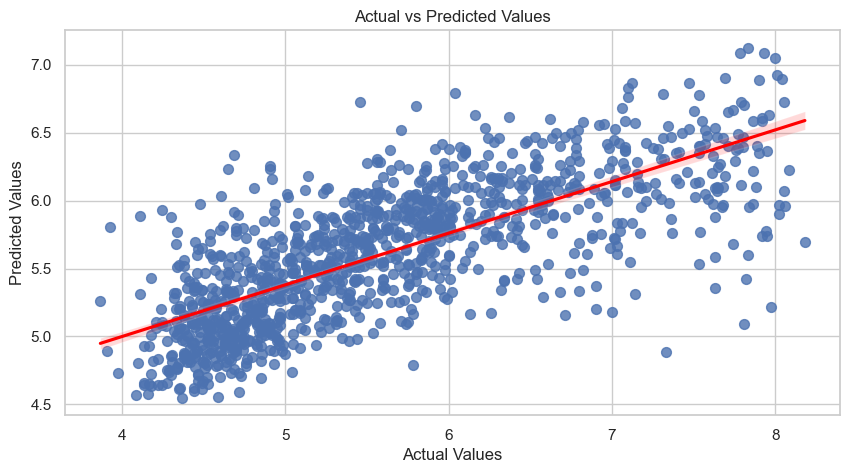

In [47]:

# 设置Seaborn样式
sns.set(style="whitegrid")

# 创建散点图和回归线
plt.figure(figsize=(10, 5))
sns.regplot(x= actual_column, y= pre_column, data=result_df[[actual_column,pre_column]], scatter_kws={'s':50}, line_kws={'color':'red'})

# 添加标题和标签
plt.title('Actual vs Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

# 显示图表
plt.show()


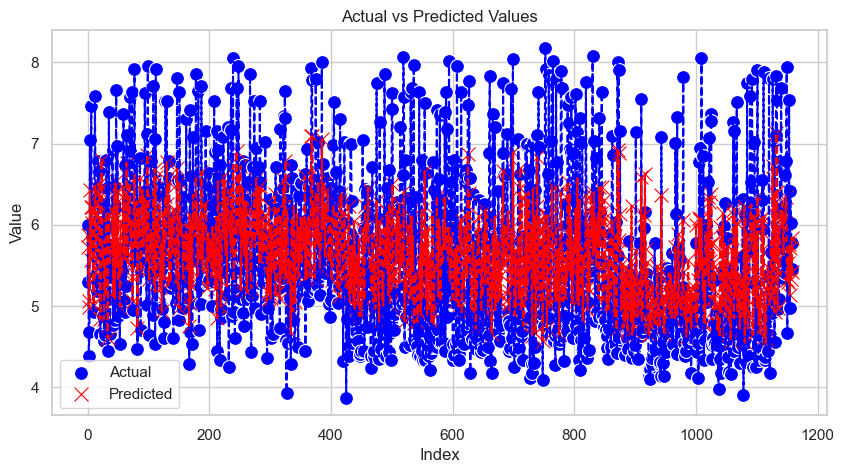

In [48]:

# 设置Seaborn样式
sns.set(style="whitegrid")

# 创建图表
plt.figure(figsize=(10, 5))

# 绘制真实值和预测值的散点图
sns.scatterplot(x=result_df.index, y=actual_column, data=result_df, color='blue', s=100, label='Actual', marker='o')
sns.scatterplot(x=result_df.index, y=pre_column, data=result_df, color='red', s=100, label='Predicted', marker='x')

# 添加回归线
sns.lineplot(x=result_df.index, y=actual_column, data=result_df, color='blue', linestyle='--')
sns.lineplot(x=result_df.index, y=pre_column, data=result_df, color='red', linestyle='--')

# 添加标题和标签
plt.title('Actual vs Predicted Values')
plt.xlabel('Index')
plt.ylabel('Value')

# 显示图表
plt.legend()
plt.show()
